## Analyse du DataSet suivant                                   (Smartphone Based Recognition Of Human Activities And Postural Transitions) : 
https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

#### Travail Réalisé par : Amir BENADOUDA
#### Contexte : Dans le cadre d'une étude (ESILV)
#### Contact : amir.benadouda@edu.devinci.fr



# Introduction

30 participants ont effectués des activités de la vie quotidienne tout en portant un smartphone à leur ceinture. Grâce à la centrale inertielle dont le smartphone est équipé, il fut possible de configurer ce dernier pour enregistrer les mouvements de ces personnes, et notamment leurs positions (allongé, debout, assis, etc.). Ainsi, les données prdouites nous proviennent de deux capteurs : Un accéléromètre et un gyroscope.
#### Le jeu de données à, de ce fait, pu être partitionné de façon aléatoire et intrasèque. Par la suite, nous retrouverons une selection de 70% des volontaires afin de générer le dataset d'entrainement ("Train"); ainsi que les 30% retant qui serviront à générer le dataset de test ("Test").

# Importation des différentes Librairies

In [1]:
# Pour la manipulation et l'analyse des données
import pandas as pd

# Pour copier différentes variables
import copy

# Pour l'usage de divers fonctions mathématiques, ainsi que la manipulation de tableaux multidimensionnels
import numpy as np
from numpy import pi

# Pour engendrer des graphs à partir de nos données
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

# Pour produire des graphs de meilleur qualité
import seaborn as sns 

# Pour créer des graphs interactifs
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pour prendre en charge des comptages pratiques et rapides
from collections import Counter

from cycler import cycler

from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# Pour la construction des modèles
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Pour la mise en place du reseau de neurones
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

# Pour gbm light (Framework nous permettant d'utilise des algorithmes d'apprentissage basés sur des arbres)
from lightgbm import LGBMClassifier

# Pour la mesure du temps
from time import time

Using TensorFlow backend.


# Importation des données

In [2]:
# Importation du nom des colonnes, et suppression des espaces
index_column = pd.read_csv('features.txt', header=None, sep="\n")
index_column = index_column.loc[:,0].str.strip()

# Importation des données de train
X_train_df = pd.read_csv('Train/X_train.txt', sep=" ", header=None)
Y_train_df = pd.read_csv('Train/y_train.txt', names={"id_label"}, header=None)

# Importation des données de test
X_test_df = pd.read_csv('Test/X_test.txt', sep=" ", header=None)
Y_test_df = pd.read_csv('Test/y_test.txt', names={"id_label"}, header=None)

# Insertion des noms des colonnes
X_train_df.columns = index_column.values
X_test_df.columns = index_column.values

In [3]:
# Chargement des labels des activités
activity_label_df = pd.read_csv('activity_labels.txt', sep="\n", names={"activity"}, header=None)
activity_label_df['id_label'] = activity_label_df['activity'].str[0:2].astype('int64')
activity_label_df['activity'] = activity_label_df['activity'].str[2:]
activity_label_df['activity'] = activity_label_df['activity'].str.strip().astype('category')

activity_label_df

,activity,id_label
0,WALKING,1
1,WALKING_UPSTAIRS,2
2,WALKING_DOWNSTAIRS,3
3,SITTING,4
4,STANDING,5
5,LAYING,6
6,STAND_TO_SIT,7
7,SIT_TO_STAND,8
8,SIT_TO_LIE,9
9,LIE_TO_SIT,10


In [4]:
# On fusionne les données grâce à "merge"
Y_train_df = pd.merge(Y_train_df, activity_label_df, on='id_label', how='left', sort=False)
Y_test_df = pd.merge(Y_test_df, activity_label_df, on='id_label', how='left', sort=False)

# On affiche les 25 premières valeurs
Y_test_df.head(25)

,id_label,activity
0,5,STANDING
1,5,STANDING
2,5,STANDING
3,5,STANDING
4,5,STANDING
5,5,STANDING
6,5,STANDING
7,5,STANDING
8,5,STANDING
9,5,STANDING


In [5]:
# Récupération de tous les id des personnes ayant été sujet pour l'expérience
subject_id_train_df = pd.read_csv('Train/subject_id_train.txt', sep="\n", names={"subject"}, header=None)
subject_id_test_df = pd.read_csv('Test/subject_id_test.txt', sep="\n", names={"subject"}, header=None)

X_train_df.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,0.430891,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.137735,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080


In [6]:
train_df = copy.copy(X_train_df)
train_df['subject'] = subject_id_train_df['subject']
train_df['Activity'] = Y_train_df['activity']

test_df = copy.copy(X_test_df)
test_df['subject'] = subject_id_test_df['subject']
test_df['Activity'] = Y_test_df['activity']

# Combinaison de Train et Test en un seul jeux de données
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Creation des labels
label = both_df.pop('Activity')

# Taille de Train et Test
print('Shape Train:\t{}'.format(X_train_df.shape))
print('Shape Test:\t{}\n'.format(X_test_df.shape))

train_df.head()

Shape Train:	(7767, 561)
Shape Test:	(3162, 561)



,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity,Data
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,STANDING,Train
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,STANDING,Train
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,STANDING,Train
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,STANDING,Train
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,STANDING,Train


# Visualisation et Modélisation de nos données

## Visualisation de nos "features"

#### Avant toute chose, qu'est-ce que c'est ? Que représentent les "features" ? 

##### Pour résumer, ce sont différentes caractéristiques  sélectionnées pour cette base de données; comme l'ange entre deux vecteurs, la moyenne des fréquences mesurées, l'energie mesurée, etc . Ces caractéristiques proviennent des signaux émis par les différents capteurs présents sur un smartphone. Tout nous est expliqué, et approfondi dans le fichier "features_info.txt" présent sur mon repository. Et pour avoir la totalité des variables de chaques features, vous pouvez les appercevoir dans le fichier "features.txt" egalement présent sur mon repository. 

##### Voici un preview de la description (un conseil, mieux vaux que vous parliez anglais 😵)

Feature Selection

=================

The features selected for this database come from the accelerometer and gyroscope 3-axial raw signals tAcc-XYZ and tGyro-XYZ. These time domain signals (prefix 't' to denote time) were captured at a constant rate of 50 Hz. Then they were filtered using a median filter and a 3rd order low pass Butterworth filter with a corner frequency of 20 Hz to remove noise. Similarly, the acceleration signal was then separated into body and gravity acceleration signals (tBodyAcc-XYZ and tGravityAcc-XYZ) using another low pass Butterworth filter with a corner frequency of 0.3 Hz. 

Subsequently, the body linear acceleration and angular velocity were derived in time to obtain Jerk signals (tBodyAccJerk-XYZ and tBodyGyroJerk-XYZ). Also the magnitude of these three-dimensional signals were calculated using the Euclidean norm (tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag). 

Finally a Fast Fourier Transform (FFT) was applied to some of these signals producing fBodyAcc-XYZ, fBodyAccJerk-XYZ, fBodyGyro-XYZ, fBodyAccJerkMag, fBodyGyroMag, fBodyGyroJerkMag. (Note the 'f' to indicate frequency domain signals). 

These signals were used to estimate variables of the feature vector for each pattern:  
'-XYZ' is used to denote 3-axial signals in the X, Y and Z directions.

tBodyAcc-XYZ

tGravityAcc-XYZ

tBodyAccJerk-XYZ

tBodyGyro-XYZ

tBodyGyroJerk-XYZ

tBodyAccMag

tGravityAccMag

tBodyAccJerkMag

tBodyGyroMag

tBodyGyroJerkMag

fBodyAcc-XYZ

fBodyAccJerk-XYZ

fBodyGyro-XYZ

fBodyAccMag

fBodyAccJerkMag

fBodyGyroMag

fBodyGyroJerkMag

#### En voici une brève visualisation :

In [7]:
X_train_df.dtypes

tBodyAcc-Mean-1                    float64
tBodyAcc-Mean-2                    float64
tBodyAcc-Mean-3                    float64
tBodyAcc-STD-1                     float64
tBodyAcc-STD-2                     float64
                                    ...   
tBodyGyro-AngleWRTGravity-1        float64
tBodyGyroJerk-AngleWRTGravity-1    float64
tXAxisAcc-AngleWRTGravity-1        float64
tYAxisAcc-AngleWRTGravity-1        float64
tZAxisAcc-AngleWRTGravity-1        float64
Length: 561, dtype: object

In [8]:
Y_train_df.dtypes

id_label       int64
activity    category
dtype: object

In [9]:
# Récupération des valeurs nulles et des informations sur le DataFrame
print('Valeurs Nulles dans le DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Valeurs Nulles dans le DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929 entries, 0 to 10928
Columns: 563 entries, tBodyAcc-Mean-1 to Data
dtypes: float64(561), object(2)
memory usage: 46.9+ MB


## Distribution des Données

In [10]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

# Sur le graph suivant, vous pouvez apprécier la distribution des différentes activités mesurées.
# Ce graphique est interactif, en passant la souris sur les labels, vous verrez les valeurs associées.
# Vous pouvez egalement zoomer, ou retrecir le graph grâce au curseur. Pour revenir à la forme initiale,
# il vous suffit de double cliquer sur ce dernier.

###### On peut ainsi remarquer que finalement, la répartition de nos données est assez equilibrée.

## Séparation des différentes Activités grâce au t-SNE

#### L'algorithme t-SNE (t-distributed stochastic neighbor embedding) que nous allons utiliser maintenant, est une technique de réduction de dimension pour la visualisation de données développée par Geoffrey Hinton et Laurens van der Maaten.

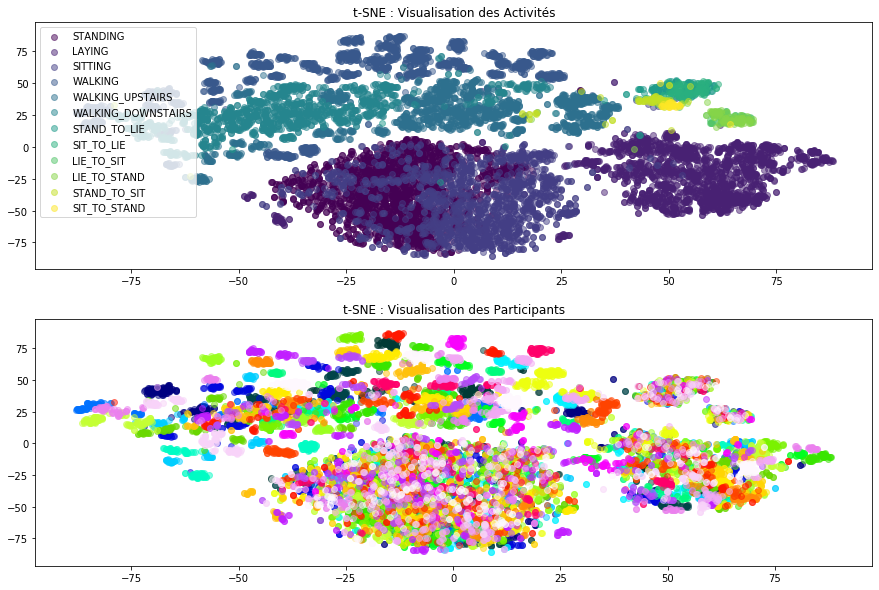

In [11]:
# Création des DataSets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Echelonnage des Données
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Réduction des dimensions (afin d'accroître la rapidité de traitement)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transformation des Données
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

# Création des subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))


## Visualisation des Activités ##
# Attribution des différentes Couleurs
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot par Activité
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('t-SNE : Visualisation des Activités')
axarr[0].legend()

## Visualisation des Participants ##
# Attribution des différentes Couleurs
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot par Participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[1].set_title('t-SNE : Visualisation des Participants')

plt.show()

##### Sur le premier graph, on pourra distinctement apprécier la séparation des différentes activités. Tandis que sur le second graph, on pourra remarquer les différentes personnes sujettes à l'expèrience, ainsi que les informations qui en découlent. De ce fait, on pourrai imaginer retrouver chaque personnes en fonctions des différents styles d'informations de celle-ci ! En observant ce graph, on peut clairement voir la distinction entre chaque personne.

## Modèles et Prédictions

### Désormais, nous allons tenter d'aller plus loin concernant l'analyse des personnes et de leur activités, en testant différent algorithmes et modèles mathématiques de prédiction.


### A) Support Vector Machine (SVM Classifier)

#### Les machines à vecteurs de support ou séparateurs à vaste marge sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. Les SVM sont une généralisation des classifieurs linéaires. Les séparateurs à vaste marge ont été développés dans les années 1990 à partir des considérations théoriques de Vladimir Vapnik sur le développement d'une théorie statistique de l'apprentissage : la théorie de Vapnik-Tchervonenkis. Ils ont rapidement été adoptés pour leur capacité à travailler avec des données de grandes dimensions, le faible nombre d'hyperparamètres, leurs garanties théoriques, et leurs bons résultats en pratique. Les SVM ont été appliqués à de très nombreux domaines (bio-informatique, recherche d'information, vision par ordinateur, finance…). Selon les données, la performance des machines à vecteurs de support est de même ordre, ou même supérieure, à celle d'un réseau de neurones ou d'un modèle de mélanges gaussiens.

##### Nous allons donc tester un SVM Classifier en faisant varier à plusieurs reprise le paramètre C. Ce qui nous donnera plus ou moin d'efficience et de précision sur nos résultats. (Généralement, plus le paramètre C est grand, plus nos résultats sont précis et cohérents.)

In [12]:
df = pd.DataFrame(columns=['C', 'Accuracy'])
accuracy = 0
for i in range(-5,5):
        print('\nTraining linear svm... for C : {}'.format(2**i))
        lsvm_clf = svm.SVC(C=2**i, kernel='linear')
        lsvm_clf.fit(X_train_df,Y_train_df['activity'])
        print('Done!')

        print('Calculating accuracy...')
        pred = lsvm_clf.predict(X_train_df)
        acc = np.sum(pred==Y_train_df['activity'])/float(X_train_df.shape[0])
        print('Linear SVM Train Accuracy : %.4f' % acc)

        pred = lsvm_clf.predict(X_test_df)
        accuracy = np.sum(pred==Y_test_df['activity'])/float(X_test_df.shape[0])
        df = df.append({'C' : 2**i, 'Accuracy' : accuracy}, ignore_index=True)
        print('Linear SVM Validation Accuracy for C = %f: %.4f' % (2**i,accuracy))


Training linear svm... for C : 0.03125
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9802
Linear SVM Validation Accuracy for C = 0.031250: 0.9488

Training linear svm... for C : 0.0625
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9849
Linear SVM Validation Accuracy for C = 0.062500: 0.9488

Training linear svm... for C : 0.125
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9879
Linear SVM Validation Accuracy for C = 0.125000: 0.9494

Training linear svm... for C : 0.25
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9911
Linear SVM Validation Accuracy for C = 0.250000: 0.9532

Training linear svm... for C : 0.5
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9928
Linear SVM Validation Accuracy for C = 0.500000: 0.9526

Training linear svm... for C : 1
Done!
Calculating accuracy...
Linear SVM Train Accuracy : 0.9930
Linear SVM Validation Accuracy for C = 1.000000: 0.9519

Training linear svm... for C : 2
Done!
Calculatin

###### Notre modèle a très bien fonctionné. A vu d'oeil, le meilleur résultat qu'on puisse avoir est une précision de 95,4% en prenant un C de 16. Exposons tout cela au travers d'un graph, et assurons nous de notre coup d'oeil en cherchant l'Accuracy maximale.

,C,Accuracy
9,16.0,0.95351


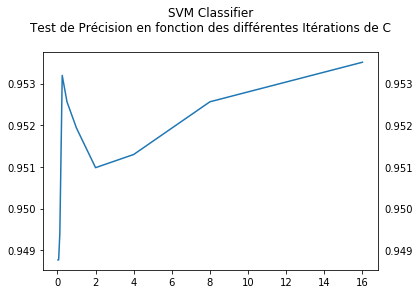

In [13]:
#Création du graph
plt.figure()
plt.plot(df['C'], df['Accuracy'])
plt.tick_params(labelright = True)
plt.title('SVM Classifier\nTest de Précision en fonction des différentes Itérations de C\n ')

# Récupération de la meilleure précision obtenue
df[df['Accuracy'] == max(df['Accuracy'])]

###### Ainsi, les resultats obtenues grâce au SVM Classifier sont satisfaisants.

### B) Random Forest Classifer vs Logistic Regression vs Linear Support Vector Classification

#### Random Forest Classifier
#### Les forêts d'arbres décisionnels1 (ou forêts aléatoires de l'anglais random forest classifier) ont été premièrement proposées par Ho en 19952 et ont été formellement proposées en 2001 par Leo Breiman et Adèle Cutler. Elles font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

#### Logistic Regression
#### La régression logistique ou modèle logit est un modèle de régression binomiale. Comme pour tous les modèles de régression binomiale, il s'agit de modéliser au mieux un modèle mathématique simple à des observations réelles nombreuses. En d'autres termes d'associer à un vecteur de variables aléatoires (x1,x2, .... , xk) à une variable aléatoire binomiale génériquement notée y. La régression logistique constitue un cas particulier de modèle linéaire généralisé. Elle est largement utilisée en apprentissage automatique. La régression logistique est largement répandue dans de nombreux domaines. On peut citer de façon non exhaustive : 
#### - En médecine, elle permet par exemple de trouver les facteurs qui caractérisent un groupe de sujets malades par rapport à des sujets sains.
#### - Dans le domaine des assurances, elle permet de cibler une fraction de la clientèle qui sera sensible à une police d’assurance sur tel ou tel risque particulier.
#### - Dans le domaine bancaire, pour détecter les groupes à risque lors de la souscription d’un crédit.
#### - En économétrie, pour expliquer une variable discrète. Par exemple, les intentions de vote aux élections.
#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Tentons désormais de défénir ces trois modèles, afin d'avoir la possiblité de les comparer par la suite.

C:\Users\amirb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\amirb\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\amirb\Anaconda3\lib\site-packages

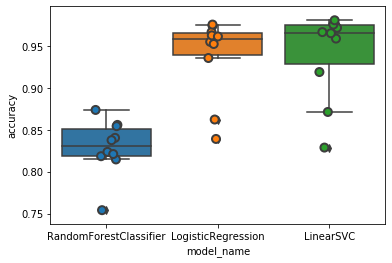

In [14]:
#Définition des modèles
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(random_state=0, multi_class='multinomial', max_iter=200),
    LinearSVC(),
]

#Nombre de cross validation
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_df, Y_train_df['activity'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

## J'ai essayé de faire varier le nombre maximum d'iterations, mais même avec "max_iter=1", j'obtiens
## toujours les mêmes avertissements. Quoi qu'il en soit le graphique produit est satisfaisant pout notre
## étude, mais si vous avez la solution pour supprimer ces erreurs je suis preneur.

## Pour accéder au graphique, veuillez scroller tout en bas du Outpout, après les avertissements.

###### A vu d'oeil, d'après ce graphique ci-dessus, le modèle LinearSVC est plus performant que les autre modèles dans ce contexte d'étude. Il chevauche de peu le modèle de Regression Logistique (logit). Avec pour la dernière place le RandomForest qui n'est pas si mal, mais tout de même loin derrière les deux autres.

##### Afin d'être certain, nous allons retirer la moyenne de toutes "accuracy" en les groupant par chaque modèle.

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.941303
LogisticRegression        0.938468
RandomForestClassifier    0.829416
Name: accuracy, dtype: float64

#### En effet, comme dit plus haut, et en concordance avec nos graphs, on obtient alors la certitude que le modèle produisant les résultats les plus précis est le : Linear Support Vector Classification (Linear SVC).

### C) Réseau de Neurones

#### Un réseau de neurones artificiels, ou réseau neuronal artificiel, est un système dont la conception est à l'origine schématiquement inspirée du fonctionnement des neurones biologiques, et qui par la suite s'est rapproché des méthodes statistiques. Les réseaux de neurones sont généralement optimisés par des méthodes d’apprentissage de type probabiliste, en particulier bayésien. Ils sont placés d’une part dans la famille des applications statistiques, qu’ils enrichissent avec un ensemble de paradigmes permettant de créer des classifications rapides (réseaux de Kohonen en particulier), et d’autre part dans la famille des méthodes de l’intelligence artificielle auxquelles ils fournissent un mécanisme perceptif indépendant des idées propres de l'implémenteur, et fournissant des informations d'entrée au raisonnement logique formel.

##### Ici, nous allons utiliser la librairie python "keras" (importée tout au début de notre étude) pour modeliser et entrainer notre réseau de neurones.

In [16]:
# Définition des différentes couches de notre modèle
model = Sequential()
model.add(Dense(561, input_dim=561, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(12, activation='softmax'))

# Compilation du modèle
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

y_train = keras.utils.to_categorical(Y_train_df['id_label'] - 1, num_classes=12)
y_test = keras.utils.to_categorical(Y_test_df['id_label'] - 1, num_classes=12)

In [17]:
# Entrainement du reseau de neurone sur le dataset de train
# On allonge la durée de l'entrainement en paramétrant le nombre d'époques sur 100

history = model.fit(X_train_df, y_train, validation_data=(X_test_df, y_test), epochs=100, batch_size=10)

Train on 7767 samples, validate on 3162 samples
Epoch 1/100
7767/7767 [==============================] - 4s 465us/step - loss: 0.6697 - accuracy: 0.7258 - val_loss: 0.4394 - val_accuracy: 0.8121
Epoch 2/100
7767/7767 [==============================] - 3s 450us/step - loss: 0.3403 - accuracy: 0.8622 - val_loss: 0.3618 - val_accuracy: 0.8684
Epoch 3/100
7767/7767 [==============================] - 3s 442us/step - loss: 0.2646 - accuracy: 0.8911 - val_loss: 0.2564 - val_accuracy: 0.9083
Epoch 4/100
7767/7767 [==============================] - 4s 515us/step - loss: 0.2401 - accuracy: 0.9010 - val_loss: 0.2419 - val_accuracy: 0.9137
Epoch 5/100
7767/7767 [==============================] - 4s 565us/step - loss: 0.2171 - accuracy: 0.9153 - val_loss: 0.2848 - val_accuracy: 0.9010
Epoch 6/100
7767/7767 [==============================] - 3s 439us/step - loss: 0.2097 - accuracy: 0.9127 - val_loss: 0.3011 - val_accuracy: 0.8915
Epoch 7/100
7767/7767 [==============================] - 5s 587us/step

7767/7767 [==============================] - 4s 538us/step - loss: 0.0576 - accuracy: 0.9791 - val_loss: 0.2779 - val_accuracy: 0.9225
Epoch 57/100
7767/7767 [==============================] - 4s 479us/step - loss: 0.0616 - accuracy: 0.9752 - val_loss: 0.3622 - val_accuracy: 0.9039
Epoch 58/100
7767/7767 [==============================] - 4s 496us/step - loss: 0.0600 - accuracy: 0.9755 - val_loss: 0.1978 - val_accuracy: 0.9409
Epoch 59/100
7767/7767 [==============================] - 4s 507us/step - loss: 0.0484 - accuracy: 0.9791 - val_loss: 0.2036 - val_accuracy: 0.9399
Epoch 60/100
7767/7767 [==============================] - 4s 553us/step - loss: 0.0647 - accuracy: 0.9744 - val_loss: 0.2102 - val_accuracy: 0.9402
Epoch 61/100
7767/7767 [==============================] - 4s 470us/step - loss: 0.0530 - accuracy: 0.9780 - val_loss: 0.2178 - val_accuracy: 0.9371
Epoch 62/100
7767/7767 [==============================] - 4s 494us/step - loss: 0.0528 - accuracy: 0.9782 - val_loss: 0.2535 

In [18]:
# On evalue notre modèle et récupère la précision moyenne des résultats produits

_, train_accuracy = model.evaluate(X_train_df, y_train, verbose=0)
_, test_accuracy = model.evaluate(X_test_df, y_test, verbose=0)

test_accuracy

0.9389626979827881

        Train : 0.995, Test : 0.939


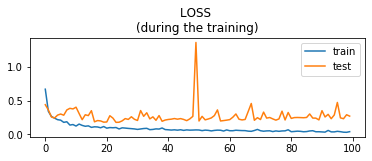

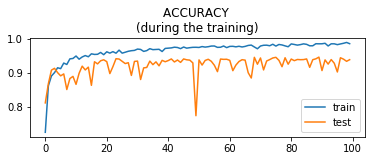

In [19]:
print('        Train : %.3f, Test : %.3f' % (train_accuracy, test_accuracy))

# plot du loss pendant l'entrainement
plt.subplot(211)
plt.title('LOSS \n(during the training)')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# plot de la précision pendant l'entrainement
plt.subplot(212)
plt.title('ACCURACY \n(during the training)')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#### Les résultats délivrés par le réseau de neurones sont assez satisfaisants, malgrè que l'on décèle une certaine irrégularité lors de l'acquisition de précision à travers toute la durée de l'entrainement.

####       

# Conclusion

### Grâce à notre étude, on comprend que l'activité d'un utilisateur de smartphone est facilement prédictible avec une précision variant entre 90% et 95%. Les données des gyroscopes et accéléromètres sont aisément exploitable.